In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.manifold import TSNE,MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [2]:
data = load_iris()

In [3]:
df = pd.DataFrame(data.data,columns=data.feature_names)
df['flor'] = data.target
df['flor'].replace(dict(zip(range(3),data.target_names)),inplace=True)

In [4]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),flor
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Visualización

In [5]:
varc = data.feature_names[:]

In [6]:
X = df[varc].copy()

In [7]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

pca = PCA(n_components=2)
pca.fit(Xs)
pca.explained_variance_ratio_.cumsum()

Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

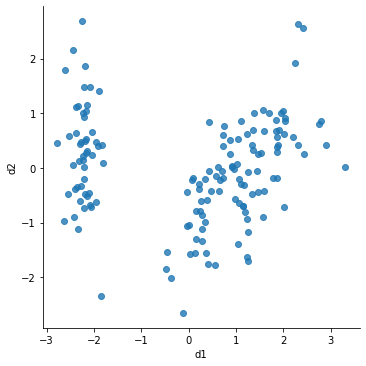

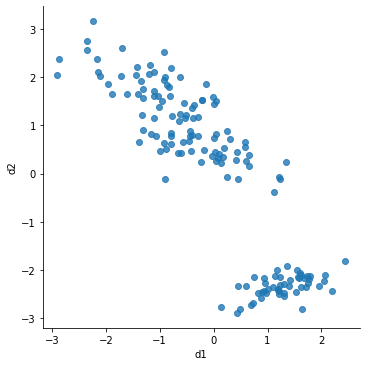

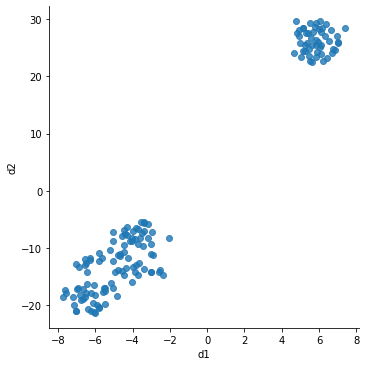

In [8]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

## Modelo no supervisado (Aglomerativo)

In [9]:
cluster = AgglomerativeClustering(n_clusters=3,linkage='average')

In [10]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

In [11]:
Xs['cl'] = Xp['cl'] =Xm['cl'] =Xt['cl'] =cluster.fit_predict(Xs)
Xs['flor'] = Xp['flor'] =Xm['flor'] =Xt['flor'] =df['flor']

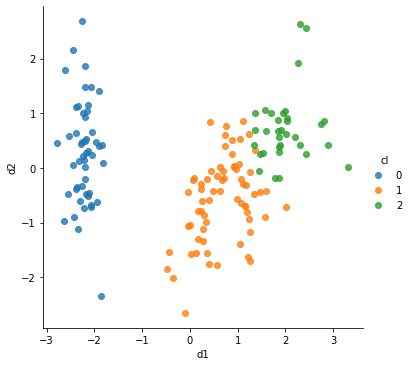

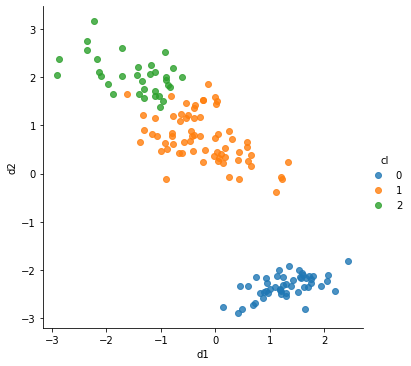

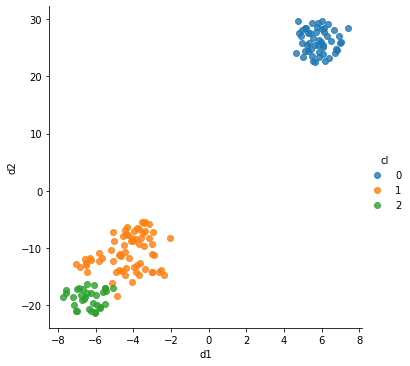

In [12]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

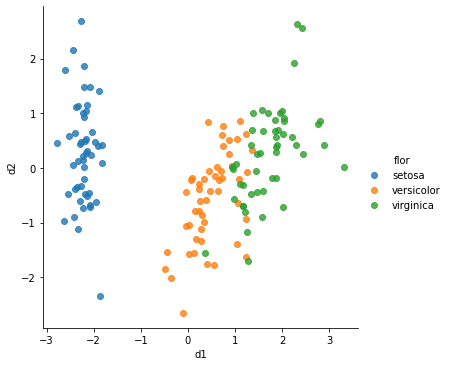

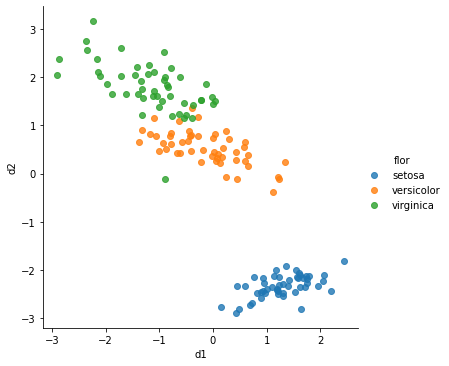

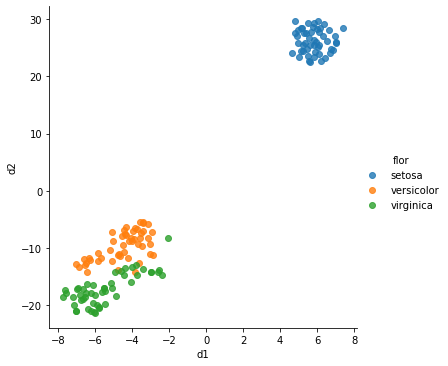

In [13]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='flor')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='flor')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='flor')

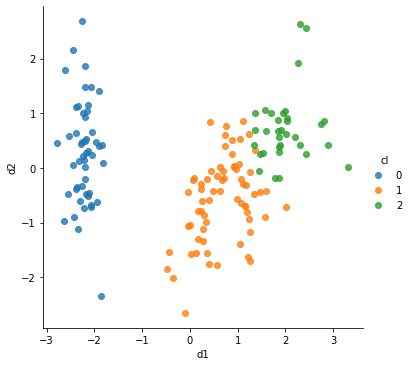

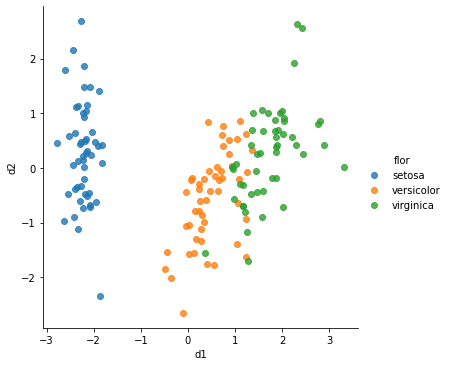

In [14]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='flor')

In [15]:
Xs[['cl','flor']].assign(n=1).pivot_table(index='cl',
                                          fill_value=0,
                                          columns='flor',
                                          values='n',
                                          aggfunc='sum')

flor,setosa,versicolor,virginica
cl,,,
0,50,0,0
1,0,50,17
2,0,0,33


## K-Medias

In [16]:
df = pd.read_excel('data/Datos Antropométricos.xlsx')

In [17]:
varc = ['Estatura (cm)', 'Peso (kg)', 'Talla Zapato (27,28,etc)', 'Edad']

In [18]:
X = df[varc].copy()

In [19]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

pca = PCA(n_components=2)
pca.fit(Xs)
print(pca.explained_variance_ratio_.cumsum())

Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

[0.44272375 0.70328042]


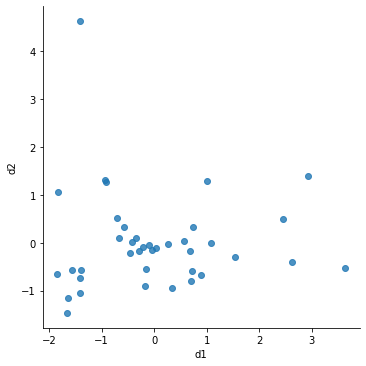

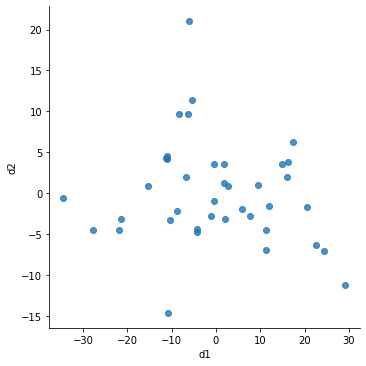

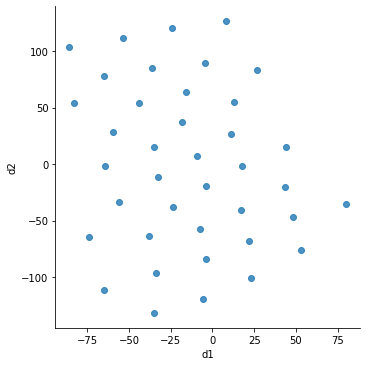

In [20]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

In [21]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

In [22]:
l_in = []
for k in range(2,10):
    cl = KMeans(n_clusters=k,)
    cl.fit(Xs)
    l_in.append(cl.inertia_)

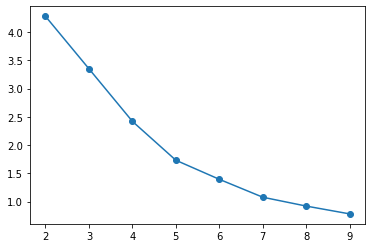

In [23]:
plt.plot(range(2,10),l_in,marker='o')

In [24]:
cluster = KMeans(n_clusters=5)

In [25]:
df.columns

Index(['Estatura (cm)', 'Peso (kg)', 'Talla Zapato (27,28,etc)', 'Edad',
       'Sexo (H,M)'],
      dtype='object')

In [26]:
Xs['cl'] = Xp['cl'] = Xm['cl'] = Xt['cl'] = cluster.fit_predict(Xs)
Xs['Sexo (H,M)'] = Xp['Sexo (H,M)'] = Xm['Sexo (H,M)'] = Xt['Sexo (H,M)'] = df['Sexo (H,M)']

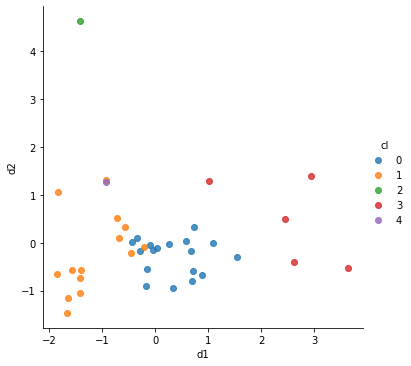

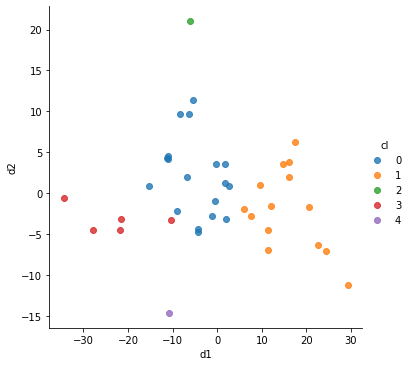

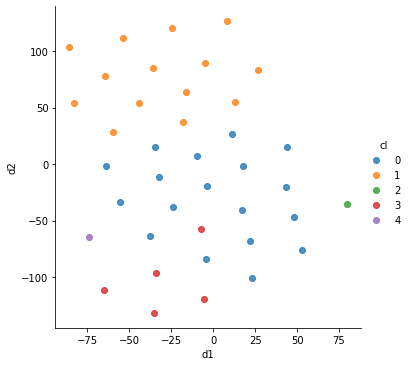

In [27]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

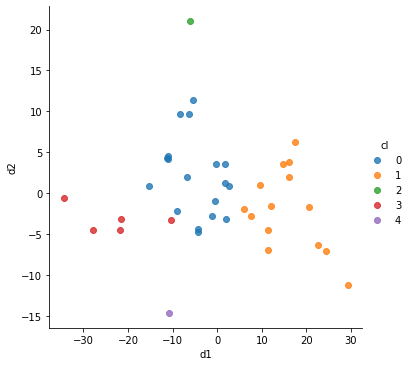

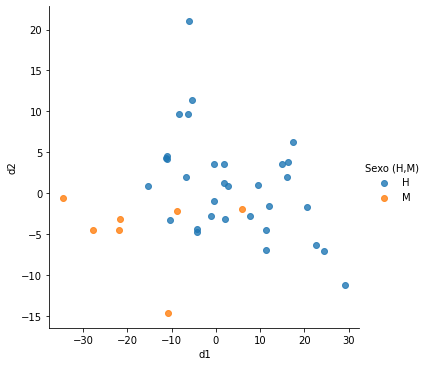

In [28]:
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='Sexo (H,M)')

In [29]:
df['cl'] = cluster.fit_predict(Xs[varc])

In [30]:
df.cl.value_counts()

0    19
1    14
3     4
4     1
2     1
Name: cl, dtype: int64

## Modelos Gaussianos Mixtos

In [67]:
from sklearn.mixture import GaussianMixture

In [68]:
df = pd.read_excel('data/Datos Antropométricos.xlsx')

In [69]:
varc = ['Estatura (cm)', 'Peso (kg)', 'Talla Zapato (27,28,etc)', 'Edad']

In [70]:
X = df[varc].copy()

In [71]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

pca = PCA(n_components=2)
pca.fit(Xs)
print(pca.explained_variance_ratio_.cumsum())

Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

[0.44272375 0.70328042]


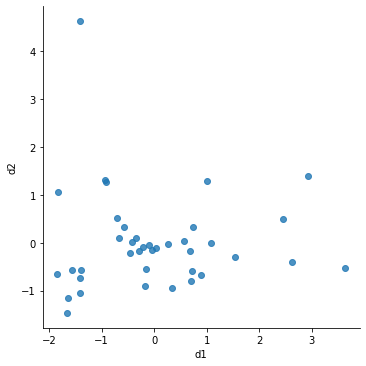

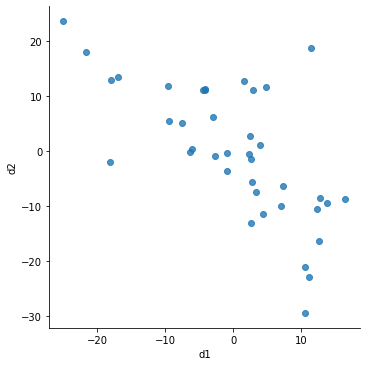

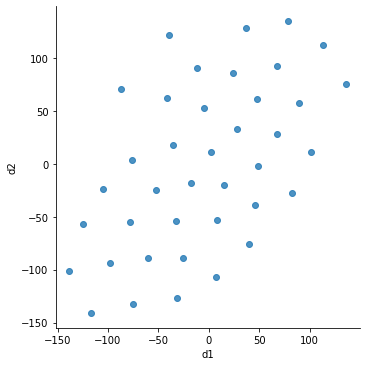

In [72]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

In [73]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

In [74]:
cluster = GaussianMixture(n_components=5)

In [75]:
Xs['cl'] = Xp['cl'] = Xm['cl'] = Xt['cl'] = cluster.fit_predict(Xs)
Xs['Sexo (H,M)'] = Xp['Sexo (H,M)'] = Xm['Sexo (H,M)'] = Xt['Sexo (H,M)'] = df['Sexo (H,M)']

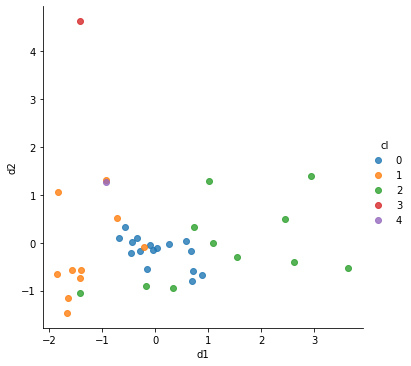

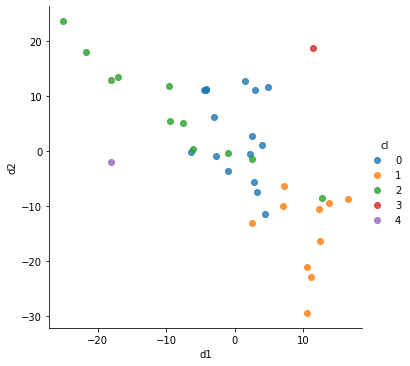

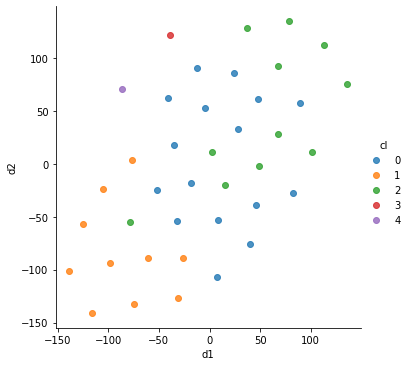

In [76]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

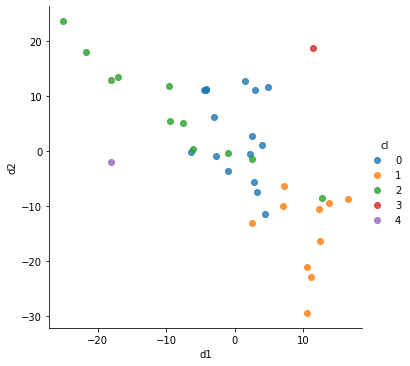

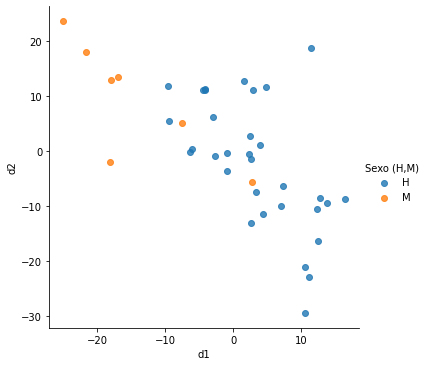

In [77]:
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='Sexo (H,M)')

In [78]:
df['cl'] = cluster.predict(Xs[varc])

In [79]:
df[[f'p_cl{i}' for i in range(5)]] = cluster.predict_proba(Xs[varc])

In [82]:
df.head()

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad,"Sexo (H,M)",cl,p_cl0,p_cl1,p_cl2,p_cl3,p_cl4
0,180,84,28.0,21,H,2,1.316802e-10,8.621570e-02,0.913784,0.0,0.0
1,172,80,27.0,23,H,0,6.891961e-01,8.327659e-07,0.310803,0.0,0.0
2,170,60,26.0,21,H,0,9.954652e-01,1.598896e-36,0.004535,0.0,0.0
3,160,65,40.0,23,M,4,1.654688e-126,0.000000e+00,0.000000,0.0,1.0
4,165,65,25.5,23,M,2,3.597924e-03,3.384469e-32,0.996402,0.0,0.0


In [83]:
cluster.means_

array([[0.61374387, 0.42826498, 0.24475793, 0.1177267 ],
       [0.76589991, 0.76453583, 0.25064383, 0.19761512],
       [0.3635828 , 0.33797637, 0.13264383, 0.15461631],
       [1.        , 0.25      , 0.41176471, 1.        ],
       [0.22580645, 0.36666667, 1.        , 0.16666667]])

In [85]:
cluster.covariances_

array([[[ 1.30706853e-02, -2.76524154e-03,  2.58194607e-03,
          5.88464896e-04],
        [-2.76524154e-03,  1.60496217e-02, -2.96491539e-04,
          8.45171709e-03],
        [ 2.58194607e-03, -2.96491539e-04,  1.86700809e-03,
          1.15880210e-04],
        [ 5.88464896e-04,  8.45171709e-03,  1.15880210e-04,
          7.08590766e-03]],

       [[ 1.57297329e-02, -4.88962119e-03,  4.90402245e-03,
         -3.36543110e-03],
        [-4.88962119e-03,  1.33310331e-02,  2.79571519e-03,
         -1.10728086e-02],
        [ 4.90402245e-03,  2.79571519e-03,  4.46665861e-03,
         -3.49916960e-03],
        [-3.36543110e-03, -1.10728086e-02, -3.49916960e-03,
          2.68125865e-02]],

       [[ 6.26073926e-02,  4.57187410e-02,  2.20142245e-02,
         -1.54317796e-02],
        [ 4.57187410e-02,  3.64096474e-02,  1.68211211e-02,
         -7.14440726e-03],
        [ 2.20142245e-02,  1.68211211e-02,  8.57484434e-03,
         -2.60270984e-03],
        [-1.54317796e-02, -7.14440726e-

In [91]:
cluster.weights_

array([0.39575988, 0.25755485, 0.29540322, 0.02564103, 0.02564103])

## Perfilamiento

In [93]:
vard = ['Sexo (H,M)']

In [102]:
df['cl'].value_counts(False).sort_index()

0    16
1    10
2    11
3     1
4     1
Name: cl, dtype: int64

In [95]:
df[['cl']+varc].groupby('cl').mean()

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad
cl,,,,
0,172.0,68.937500,27.156250,22.437500
1,176.7,88.900000,27.250000,23.400000
2,164.0,62.727273,25.181818,22.818182
3,184.0,58.000000,30.000000,33.000000
4,160.0,65.000000,40.000000,23.000000


In [99]:
df[varc].mean().to_frame().T

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad
0,170.948718,71.923077,27.025641,23.076923


In [104]:
pd.concat([df[['cl']+varc].groupby('cl').mean(),df[varc].mean().to_frame().T],ignore_index=True).to_clipboard()

In [106]:
df.pivot_table(index='cl',columns=vard,values='Edad',aggfunc='count',fill_value=0).to_clipboard()